# Importing Required Packages

In [ ]:
! pip install googlemaps

In [ ]:
import googlemaps

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer, OrdinalEncoder, LabelEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from dateutil.parser import parse
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

# Data cleaning

In [ ]:
# Creating pandas dataframe for Jobs_KM.xlsx
df1 = pd.read_excel('/content/Jobs_KM.xlsx')

In [ ]:
# Creating pandas dataframe for Multi_pick_and_drop_2.csv
df2 = pd.read_csv('/content/Multi_pick_and_drop_2.csv', low_memory=False)

In [ ]:
# Filtering data for specific Job Id's 
filtered_df2 = df2[df2['job_id'].isin(df1['job_id'])]

In [ ]:
filtered_df2.head()

,id,created_date,date_to_move,price,job_id,tolls,pickup_area,pickup_apartment_type,pickup_floor,pickup_interbuilding,pickup_apartment_building_info,dropoff_area,dropoff_apartment_type,dropoff_floor,dropoff_interbuilding,dropoff_apartment_building_info,number_of_rooms,difficulty_level,boxes_value,location_name
384,489,2019-05-01,05/04/2019,647,489,NaN,"Huguenot Avenue, Staten Island, NY, USA",Private House,NaN,0,NaN,"Dongan Hills, Staten Island, NY, USA",Private House,NaN,NaN,2,8.0,NaN,NaN,Staten Island
385,490,2019-05-01,05/03/2019,797,490,NaN,"Keyport, NJ, USA",Private House,NaN,0,NaN,"Keyport, NJ, USA",Private House,NaN,NaN,NaN,11.0,NaN,10.0,Staten Island
386,491,2019-05-01,NaN,347,491,NaN,"Hoboken, NJ, USA",Apartment Building,4,0,1,"Morganville, Marlboro Township, NJ, USA",Private House,NaN,NaN,NaN,3.5,NaN,NaN,Staten Island
388,493,2019-05-01,NaN,947,493,NaN,"Kew Gardens, Queens, NY, USA",Apartment Building,3,0,1,"Bethlehem, PA, USA",Private House,NaN,NaN,NaN,5.0,NaN,NaN,Qns/Bk/NYC
389,494,2019-05-01,06/27/2019,1150,494,NaN,"Westerleigh, Staten Island, NY, USA",Private House,NaN,0,NaN,"Howell, NJ, USA",Private House,NaN,NaN,NaN,16.0,NaN,150.0,Staten Island


In [ ]:
df_org = filtered_df2.copy()

In [ ]:
new_df = filtered_df2.copy()

In [ ]:
new_df.shape

(36338, 20)

In [ ]:
new_df = new_df.drop(['id', 'created_date', 'date_to_move', 'pickup_apartment_type', 'pickup_floor', 'pickup_interbuilding', 'pickup_apartment_building_info', 'dropoff_apartment_type', 'dropoff_floor', 'dropoff_interbuilding', 'dropoff_apartment_building_info', 'location_name' ], axis=1)

In [ ]:
new_df.head()

,price,job_id,tolls,pickup_area,dropoff_area,number_of_rooms,difficulty_level,boxes_value
384,647,489,NaN,"Huguenot Avenue, Staten Island, NY, USA","Dongan Hills, Staten Island, NY, USA",8.0,NaN,NaN
385,797,490,NaN,"Keyport, NJ, USA","Keyport, NJ, USA",11.0,NaN,10.0
386,347,491,NaN,"Hoboken, NJ, USA","Morganville, Marlboro Township, NJ, USA",3.5,NaN,NaN
388,947,493,NaN,"Kew Gardens, Queens, NY, USA","Bethlehem, PA, USA",5.0,NaN,NaN
389,1150,494,NaN,"Westerleigh, Staten Island, NY, USA","Howell, NJ, USA",16.0,NaN,150.0


In [ ]:
# Checking Null values
null_counts = new_df.isnull().sum()
print(null_counts)

price                   0
job_id                  0
tolls               31020
pickup_area            23
dropoff_area         2044
number_of_rooms         0
difficulty_level     3991
boxes_value         10222
dtype: int64


# Preprocessing

In [ ]:
# Function to check multiple address
def multi_addr(df, column_name):
    df_cleaned = df.fillna('')
    multiple_address_rows = df_cleaned[df_cleaned[column_name].str.contains('\n', na=False)]

    print(f"\nRows with multiple {column_name}:")
    for index, row in multiple_address_rows.iterrows():
        addresses = [addr.strip() for addr in row[column_name].split('\n') if addr.strip()]

        if len(addresses) > 1:
            print(f"\nJob ID {row['job_id']}:")
            for i, address in enumerate(addresses, 1):
                print(f"  Address {i}: {address}")

**Pickup_area(multi)**

In [ ]:
# to check multiple address for pickup
multi_addr(new_df, 'pickup_area')

**Drop_off area (multi)**

In [ ]:
# to check multiple address for pickup
multi_addr(new_df, 'dropoff_area')

# Feature Extraction

Feature Extraction 1: pickup and dropoff count

In [ ]:
# Function to extract count of addresses in pickup and dropoff area
def count_addresses(address_column):
    def count_func(x):
        if pd.isna(x) or x == '' or x is None:
            return 0
        return len([addr for addr in str(x).split('\n') if addr.strip()])
    return address_column.apply(count_func)

In [ ]:
new_df['pickup_address_count'] = count_addresses(new_df['pickup_area'])
new_df['dropoff_address_count'] = count_addresses(new_df['dropoff_area'])

In [ ]:
new_df.head(10)

,price,job_id,tolls,pickup_area,dropoff_area,number_of_rooms,difficulty_level,boxes_value,pickup_address_count,dropoff_address_count
384,647,489,NaN,"Huguenot Avenue, Staten Island, NY, USA","Dongan Hills, Staten Island, NY, USA",8.00,NaN,NaN,1,1
385,797,490,NaN,"Keyport, NJ, USA","Keyport, NJ, USA",11.00,NaN,10.0,1,1
386,347,491,NaN,"Hoboken, NJ, USA","Morganville, Marlboro Township, NJ, USA",3.50,NaN,NaN,1,1
388,947,493,NaN,"Kew Gardens, Queens, NY, USA","Bethlehem, PA, USA",5.00,NaN,NaN,1,1
389,1150,494,NaN,"Westerleigh, Staten Island, NY, USA","Howell, NJ, USA",16.00,NaN,150.0,1,1
390,1097,495,NaN,"Richmond, Staten Island, NY, USA","Eltingville, Staten Island, NY, USA",16.25,NaN,50.0,1,1
391,247,496,NaN,"Staten Island, NY, USA","Linden, NJ, USA",3.25,NaN,NaN,1,1
392,550,497,NaN,"Pleasant Plains, Staten Island, NY, USA","Eltingville, Staten Island, NY, USA",7.00,NaN,NaN,1,1
393,497,498,NaN,"Huguenot Avenue, Staten Island, NY, USA","Gravesend, Brooklyn, NY, USA",3.75,NaN,NaN,1,1
394,350,499,NaN,"Bulls Head, Staten Island, NY, USA","Heartland Village, Staten Island, NY, USA",2.50,NaN,NaN,1,1


Feature Extraction 2: Calculating Distance for multiple Pickup and Dropoff Addresses

In [ ]:
def calculate_distance_and_time(new_df, api_key):
    gmaps = googlemaps.Client(key=api_key)

    new_df['total_distance_km'] = 0.0
    new_df['total_time_minutes'] = 0.0
    new_df['distance_details'] = ''
    new_df['time_details'] = ''

    for i, row in new_df.iterrows():
        def split_addresses(address_str):
            return [addr.strip() for addr in re.split(r'\n+', str(address_str)) if addr.strip()]

        pickups = split_addresses(row['pickup_area'])
        dropoffs = split_addresses(row['dropoff_area'])

        if not pickups or not dropoffs:
            continue

        total_distance = 0.0
        total_time = 0.0
        distance_log = []
        time_log = []

        try:
            if len(pickups) > 1:
                for p1, p2 in zip(pickups[:-1], pickups[1:]):
                    distance_matrix = gmaps.distance_matrix(p1, p2)
                    distance_km = distance_matrix['rows'][0]['elements'][0]['distance']['value'] / 1000
                    time_minutes = distance_matrix['rows'][0]['elements'][0]['duration']['value'] / 60

                    total_distance += distance_km
                    total_time += time_minutes

                    distance_log.append(f"{p1} → {p2}: {distance_km:.2f} km")
                    time_log.append(f"{p1} → {p2}: {time_minutes:.2f} min")

            last_pickup = pickups[-1]
            first_dropoff = dropoffs[0]
            distance_matrix = gmaps.distance_matrix(last_pickup, first_dropoff)
            distance_km = distance_matrix['rows'][0]['elements'][0]['distance']['value'] / 1000
            time_minutes = distance_matrix['rows'][0]['elements'][0]['duration']['value'] / 60

            total_distance += distance_km
            total_time += time_minutes

            distance_log.append(f"{last_pickup} → {first_dropoff}: {distance_km:.2f} km")
            time_log.append(f"{last_pickup} → {first_dropoff}: {time_minutes:.2f} min")

            if len(dropoffs) > 1:
                for d1, d2 in zip(dropoffs[:-1], dropoffs[1:]):
                    distance_matrix = gmaps.distance_matrix(d1, d2)
                    distance_km = distance_matrix['rows'][0]['elements'][0]['distance']['value'] / 1000
                    time_minutes = distance_matrix['rows'][0]['elements'][0]['duration']['value'] / 60

                    total_distance += distance_km
                    total_time += time_minutes

                    distance_log.append(f"{d1} → {d2}: {distance_km:.2f} km")
                    time_log.append(f"{d1} → {d2}: {time_minutes:.2f} min")

            new_df.at[i, 'total_distance_km'] = total_distance
            new_df.at[i, 'total_time_minutes'] = total_time
            new_df.at[i, 'distance_details'] = ' | '.join(distance_log)
            new_df.at[i, 'time_details'] = ' | '.join(time_log)

        except Exception as e:
            new_df.at[i, 'total_distance_km'] = 0.0
            new_df.at[i, 'total_time_minutes'] = 0.0
            new_df.at[i, 'distance_details'] = f"Error: {str(e)}"
            new_df.at[i, 'time_details'] = f"Error: {str(e)}"

    return new_df

In [ ]:
final_df = calculate_distance_and_time(new_df, '')

In [ ]:
final_df.shape

(36338, 14)

In [ ]:
final_df.to_csv('new_jobs_km_time.csv', index=False)

In [ ]:
final_df = final_df.drop(['time_details'], axis=1)

In [ ]:
final_df['total_time_minutes'] = final_df['total_time_minutes'] / 30

In [ ]:
final_df.head()

,price,job_id,tolls,pickup_area,dropoff_area,number_of_rooms,difficulty_level,boxes_value,pickup_address_count,dropoff_address_count,total_distance_km,total_time_minutes
384,647,489,NaN,"Huguenot Avenue, Staten Island, NY, USA","Dongan Hills, Staten Island, NY, USA",8.0,NaN,NaN,1,1,21.271,0.745000
385,797,490,NaN,"Keyport, NJ, USA","Keyport, NJ, USA",11.0,NaN,10.0,1,1,0.000,0.000000
386,347,491,NaN,"Hoboken, NJ, USA","Morganville, Marlboro Township, NJ, USA",3.5,NaN,NaN,1,1,63.796,1.753333
388,947,493,NaN,"Kew Gardens, Queens, NY, USA","Bethlehem, PA, USA",5.0,NaN,NaN,1,1,169.327,3.940556
389,1150,494,NaN,"Westerleigh, Staten Island, NY, USA","Howell, NJ, USA",16.0,NaN,150.0,1,1,67.419,1.956667


In [ ]:
final_df_1 = final_df.copy()

In [ ]:
final_df.head()

,price,job_id,tolls,pickup_area,dropoff_area,number_of_rooms,difficulty_level,boxes_value,pickup_address_count,dropoff_address_count,total_distance_km,total_time_minutes
384,647,489,NaN,"Huguenot Avenue, Staten Island, NY, USA","Dongan Hills, Staten Island, NY, USA",8.0,NaN,NaN,1,1,21.271,0.745000
385,797,490,NaN,"Keyport, NJ, USA","Keyport, NJ, USA",11.0,NaN,10.0,1,1,0.000,0.000000
386,347,491,NaN,"Hoboken, NJ, USA","Morganville, Marlboro Township, NJ, USA",3.5,NaN,NaN,1,1,63.796,1.753333
388,947,493,NaN,"Kew Gardens, Queens, NY, USA","Bethlehem, PA, USA",5.0,NaN,NaN,1,1,169.327,3.940556
389,1150,494,NaN,"Westerleigh, Staten Island, NY, USA","Howell, NJ, USA",16.0,NaN,150.0,1,1,67.419,1.956667


In [ ]:
print(max(final_df['job_id']))

44694


In [ ]:
null_counts = final_df.isnull().sum()
print(null_counts)

price                        0
job_id                       0
tolls                    31020
pickup_area                 23
dropoff_area              2044
number_of_rooms              0
difficulty_level          3991
boxes_value              10222
pickup_address_count         0
dropoff_address_count        0
total_distance_km            0
total_time_minutes           0
dtype: int64


**Final DF**

In [ ]:
df_final = final_df.drop(['job_id', 'pickup_area', 'dropoff_area', 'boxes_value'], axis=1)

In [ ]:
df_final.loc[:, 'difficulty_level'] = df_final["difficulty_level"].fillna(0)
df_final.loc[:, 'tolls'] = df_final["tolls"].fillna(0)

In [ ]:
df_final.head(10)

,price,tolls,number_of_rooms,difficulty_level,pickup_address_count,dropoff_address_count,total_distance_km,total_time_minutes
384,647,0.0,8.00,0.0,1,1,21.271,0.745000
385,797,0.0,11.00,0.0,1,1,0.000,0.000000
386,347,0.0,3.50,0.0,1,1,63.796,1.753333
388,947,0.0,5.00,0.0,1,1,169.327,3.940556
389,1150,0.0,16.00,0.0,1,1,67.419,1.956667
390,1097,0.0,16.25,0.0,1,1,5.314,0.383333
391,247,0.0,3.25,0.0,1,1,14.643,0.616667
392,550,0.0,7.00,0.0,1,1,7.359,0.392778
393,497,0.0,3.75,0.0,1,1,30.686,1.164444
394,350,0.0,2.50,0.0,1,1,2.568,0.234444


In [ ]:
df_final['price'] = df_final['price'].astype(float)
df_final['total_time_minutes'] = df_final['total_time_minutes'].astype(float)

# EDA (after effect)

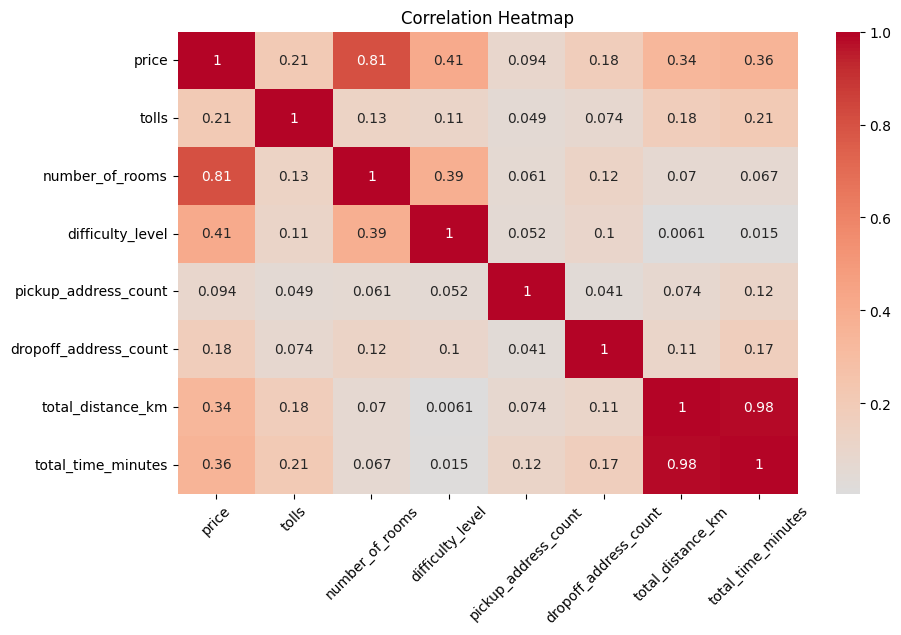

In [ ]:
# Ploting heatmap to correlation between columns
correlation_matrix = df_final.corr().round(4)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.show()

# Train, Test, Split

In [ ]:
# Spliting X and Y data
X = df_final.drop('price', axis=1)
y = df_final["price"]

In [ ]:
# Normalizing the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Spliting Train(80%) and test(20%) data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
print(X.columns)

Index(['tolls', 'number_of_rooms', 'difficulty_level', 'pickup_address_count',
       'dropoff_address_count', 'total_distance_km', 'total_time_minutes'],
      dtype='object')


# Model Training

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    bias = np.mean(y_true - y_pred)
    variance = np.var(y_pred)

    print(f"\n{model_name} :")
    print(f"R2 Score: {r2:.4f}")
    print(f"Bias: {bias:.4f}")
    print(f"Variance: {variance:.4f}")

**Random Forest**

In [ ]:
# Implementing Random Forest Model and its parameters.
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=7,
    min_samples_leaf=4,
    min_samples_split=10,
    max_features= 1.0,
)

In [ ]:
# Training Model
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [ ]:
evaluate_model(y_test, rf_pred, "Random Forest")


Random Forest :
R2 Score: 0.8448
Bias: -0.3551
Variance: 360534.4412


**Saving the Model**

# Extracting Model

In [ ]:
# Extracting trained model using Joblib module
import joblib
joblib.dump(rf_model, 'RF_model_2.pkl')

['RF_model_2.pkl']

In [ ]:
loaded_model = joblib.load('/content/RF_model_2.pkl')